In [6]:
import argparse
from glob import glob
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import time
import os
import numpy as np

parser = argparse.ArgumentParser(description='')
parser.add_argument('--epoch', dest='epoch', type=int, default=20, help='# of epochs')
parser.add_argument('--batch_size', dest='batch_size', type=int, default=128, help='# images in batch')
parser.add_argument('--lr', dest='lr', type=float, default=0.001, help='initial learning rate for adam')
parser.add_argument('--use_gpu', dest='use_gpu', type=int, default=1, help='gpu flag, 1 for GPU and 0 for CPU')
parser.add_argument('--phase', dest='phase', default='train', help='train or test')
parser.add_argument('--temporal', action='store_true', default=False, help='Use temporal model')
parser.add_argument('--checkpoint_dir', dest='ckpt_dir', default='/content/drive/MyDrive/Project/checkpoint-mixed/', help='models are saved here')
parser.add_argument('--test_dir', dest='test_dir', default='/content/drive/MyDrive/Project/output-mixed/', help='denoised sample are saved here')
args, _ = parser.parse_known_args()



In [18]:
import time
from glob import glob
import numpy as np
import tensorflow as tf
import random
import os
import cv2
from google.colab import drive
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf1
tf.compat.v1.disable_eager_execution()
tf1.disable_v2_behavior()
drive.mount('/content/drive')

def dncnn(input, is_training=True, output_channels=3):
    with tf.compat.v1.variable_scope('block1'):
        output = tf.compat.v1.layers.conv2d(input, 64, 3, padding='same', activation=tf.nn.relu)
    for layers in range(2, 19+1):
        with tf.compat.v1.compat.v1.variable_scope('block%d' % layers):
            output = tf.compat.v1.layers.conv2d(output, 64, 3, padding='same', name='conv%d' % layers, use_bias=False)
            output = tf.compat.v1.nn.relu(tf.compat.v1.layers.batch_normalization(output, training=is_training))   
    with tf.compat.v1.variable_scope('block17'):
        output = tf.compat.v1.layers.conv2d(output, output_channels, 3, padding='same',use_bias=False)
    return input - output

filepaths = glob('/content/drive/MyDrive/Project/data /Gaussian-train/original/*.png') 
filepaths = sorted(filepaths)                          
filepaths_noisy = glob('/content/drive/MyDrive/Project/data /Gaussian-train/noisy/*.png')
filepaths_noisy = sorted(filepaths_noisy)

filepaths_valid_clean = glob('/content/drive/MyDrive/Project/data /Gaussian-validation/original/*.png')
filepaths_valid_clean = sorted(filepaths_valid_clean)

filepaths_valid_noisy = glob('/content/drive/MyDrive/Project/data /Gaussian-validation/noisy/*.png')
filepaths_valid_noisy = sorted(filepaths_valid_noisy)
ind = range(len(filepaths))
#print(filepaths_noisy)

# Commented out IPython magic to ensure Python compatibility.
class denoiser(object):
    def __init__(self, sess, input_c_dim=3, batch_size=128):
        self.sess = sess
        self.input_c_dim = input_c_dim
        # build model
        self.Y_ = tf1.placeholder(tf.float32, [None, None, None, self.input_c_dim],
                                 name='clean_image')
        self.is_training = tf1.placeholder(tf.bool, name='is_training')
        self.X = tf1.placeholder(tf1.float32, [None, None, None, self.input_c_dim])
        self.Y = dncnn(self.X, is_training=self.is_training)
        self.loss = (1.0 / batch_size) * tf.nn.l2_loss(self.Y_ - self.Y)
        self.lr = tf.Variable(0.001, dtype=tf.float32, name='learning_rate')
        #self.lr = tf1.Tensor(0,tf1.float32, name='learning_rate')
        self.dataset = dataset(sess)
        #optimizer = tf.keras.optimizers.Adam(self.lr)
        optimizer = tf1.train.AdamOptimizer(self.lr)
        update_ops = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.UPDATE_OPS)
        with tf.compat.v1.control_dependencies(update_ops):
            self.train_op = optimizer.minimize(self.loss)
        init = tf.compat.v1.global_variables_initializer()
        self.sess.run(init)
        print("[*] Initialize model successfully...")

    def evaluate(self, iter_num, eval_files, noisy_files, summary_writer):
        print("[*] Evaluating...")
        numBatch = int(len(eval_files))
        psnr_sum = 0
        mse_sum = 0
        train_loss = 0
        for i in range(len(eval_files)):
            clean_image = cv2.imread(eval_files[i])
            clean_image = clean_image.astype('float32') / 255.0
            clean_image = clean_image[np.newaxis, ...]
            #clean_image = clean_image[None, :, :, :]
            noisy = cv2.imread(noisy_files[i])
            noisy = noisy.astype('float32') / 255.0
            noisy = noisy[np.newaxis, ...]
            
            output_clean_image, loss = self.sess.run(
                [self.Y, self.loss],feed_dict={self.Y_: clean_image,
                           self.X: noisy,
                           self.is_training: False})
            psnr = psnr_scaled(clean_image, output_clean_image)
            # mse = mse_scaled(clean_image, output_clean_image)
            train_loss += (loss) # average loss per batch
            print("img%d PSNR: %.2f" % (i + 1, psnr))
            psnr_sum += psnr
            # mse_sum += mse
            #loss_sum += loss

        avg_psnr = psnr_sum / len(eval_files)
        # avg_mse = mse_sum / len(eval_files)
        #avg_loss = loss_sum / len(eval_files)
        print("eva --- Test ---- Average PSNR %.2f ---" % avg_psnr)
        print("eva --- Test ---- Average loss %.2f ---" % (train_loss/numBatch))  
        # print("eva --- Test ---- Average MSE %.2f ---" % avg_mse) 
        return train_loss

    def train(self, eval_files, noisy_files, valid_clean, valid_noisy, batch_size, ckpt_dir, epoch, lr, eval_every_epoch=1):

        #numBatch = int(len(filepaths) * 2)
        numBatch = int(len(filepaths))
        # load pretrained model
        load_model_status, global_step = self.load(ckpt_dir)
        if load_model_status:
            iter_num = global_step
            start_epoch = global_step // numBatch
            start_step = global_step % numBatch
            print("[*] Model restore success!")
        else:
            iter_num = 0
            start_epoch = 0
            start_step = 0
            print("[*] Not find pretrained model!")
        # make summary
        tf1.summary.scalar('loss', self.loss)
        tf1.summary.scalar('lr', self.lr)
        print('collections', tf1.get_collection(tf1.GraphKeys.SUMMARIES))
        #writer = tf1.summary.FileWriter('./logs', self.sess.graph)
        #merged = tf1.summary.merge_all()
        writer = tf.compat.v1.summary.FileWriter('./logs', self.sess.graph)
        merged = tf.compat.v1.summary.merge_all()
        print('xx',merged)
        clip_all_weights = tf1.get_collection("max_norm")        

        print("[*] Start training, with start epoch %d start iter %d : " % (start_epoch, iter_num))
        start_time = time.time()
        self.evaluate(iter_num, eval_files, noisy_files, summary_writer=writer)  # eval_data value range is 0-255

        ####################
        train_loss_epoch = []
        valid_loss_epoch = []
        ####################
        for epoch in range(start_epoch, epoch):
            train_loss = 0
            batch_noisy = np.zeros((batch_size,64,64,3),dtype='float32')
            batch_images = np.zeros((batch_size,64,64,3),dtype='float32')
            for batch_id in range(start_step, numBatch):
              try:
                res = self.dataset.get_batch() # If we get an error retrieving a batch of patches we have to reinitialize the dataset
              except KeyboardInterrupt:
                raise
              except:
                self.dataset = dataset(self.sess) # Dataset re init
                res = self.dataset.get_batch()
              if batch_id==0:
                batch_noisy = np.zeros((batch_size,64,64,3),dtype='float32')
                batch_images = np.zeros((batch_size,64,64,3),dtype='float32')
              ind1 = range(int(res.shape[0]/2))
              ind1 = np.multiply(ind1,2)

              for i in range(batch_size):
                random.shuffle(ind1)
                ind2 = random.randint(0,8-1)
                batch_noisy[i] = res[ind1[0],ind2]
                batch_images[i] = res[ind1[0]+1,ind2]
                #print('x', [self.train_op, self.loss, merged])
              _, loss, summary = self.sess.run(fetches = [self.train_op, self.loss, merged],
                                                 feed_dict={self.Y_: batch_images, self.X: batch_noisy, self.lr: lr[epoch],
                                                            self.is_training: True})
              self.sess.run(clip_all_weights)
              train_loss += (loss/batch_size) # average loss per batch
              print("Epoch: [%2d] [%4d/%4d] time: %4.4f, loss: %.6f"
                     % (epoch + 1, batch_id + 1, numBatch, time.time() - start_time, loss))
              iter_num += 1
              writer.add_summary(summary, iter_num)
              
            if np.mod(epoch + 1, eval_every_epoch) == 0: ##Evaluate and save model
                valid_loss = self.evaluate(iter_num, valid_clean, valid_noisy, summary_writer=writer)
                valid_loss_epoch.append(valid_loss/numBatch)
                # train_loss_v2 = self.evaluate(iter_num, eval_files, noisy_files, summary_writer=writer)
                train_loss_epoch.append(train_loss/numBatch)
                #self.save(iter_num, ckpt_dir)
            print("Epoch: [%d] average train loss: %4d" % (epoch+1, train_loss/numBatch))
        print("[*] Training finished.")
        print(valid_loss_epoch)
        print(train_loss_epoch)

        # plot the train and valid losses when training is complete
        fig=plt.figure()
        plt.plot(train_loss_epoch, label="train")
        plt.plot(valid_loss_epoch, label="validation")
        plt.title("Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        fig.savefig("/content/drive/MyDrive/Project/train-loss.png")
        plt.show()

        # record losses in file
        file = open(ckpt_dir+'small-set-train.txt', 'w')
        file.writelines("train, loss\n")
        for x,y in zip(train_loss_epoch, valid_loss_epoch):
          file.writelines("%f, %f\n" % (x,y))
        file.close()

    def save(self, iter_num, ckpt_dir, model_name='DnCNN-tensorflow'):
        saver = tf1.train.Saver()
        checkpoint_dir = ckpt_dir
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)
        print("[*] Saving model...")
        saver.save(self.sess,
                   os.path.join(checkpoint_dir, model_name),
                   global_step=iter_num)

    def load(self, checkpoint_dir):
        print("[*] Reading checkpoint...")
        saver = tf1.train.Saver()
        ckpt = tf1.train.get_checkpoint_state(checkpoint_dir)
        if ckpt and ckpt.model_checkpoint_path:
            full_path = tf1.train.latest_checkpoint(checkpoint_dir)
            global_step = int(full_path.split('/')[-1].split('-')[-1])
            saver.restore(self.sess, full_path)
            return True, global_step
        else:
            return False, 0

    def test(self, eval_files, noisy_files, ckpt_dir, save_dir, temporal):
        """Test DnCNN"""
        # init variables
        tf1.global_variables_initializer().run()
        assert len(eval_files) != 0, 'No testing data!'
        load_model_status, global_step = self.load(ckpt_dir)
        assert load_model_status == True, '[!] Load weights FAILED...'
        print(" [*] Load weights SUCCESS...")
        psnr_sum = 0
            
        for i in range(len(eval_files)):
            clean_image = cv2.imread(eval_files[i])
            clean_image = clean_image.astype('float32') / 255.0
            clean_image = clean_image[np.newaxis, ...]
            
            noisy = cv2.imread(noisy_files[i])
            noisy = noisy.astype('float32') / 255.0
            noisy = noisy[np.newaxis, ...] 
          
            output_clean_image = self.sess.run(
                [self.Y],feed_dict={self.Y_: clean_image, self.X: noisy,
                                    self.is_training: False})
            
            out1 = np.asarray(output_clean_image)
               
            psnr = psnr_scaled(clean_image, out1[0,0])
            psnr1 = psnr_scaled(clean_image, noisy)
            
            print("img%d PSNR: %.2f , noisy PSNR: %.2f" % (i + 1, psnr, psnr1))
            psnr_sum += psnr

            cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/data/denoised/%04d.png'%(i),out1[0,0]*255.0)

        avg_psnr = psnr_sum / len(eval_files)
        print("test: --- Test ---- Average PSNR %.2f ---" % avg_psnr)

    
class dataset(object):
  def __init__(self,sess):
    self.sess = sess
    seed = time.time()
    random.seed(seed)
    idxs = list(ind)
    random.shuffle(idxs)
    
    filenames = list()
    for i in range(len(filepaths)):
        filenames.append(filepaths_noisy[idxs[i]])
        filenames.append(filepaths[idxs[i]])

    # Parameters
    num_patches = 8   # number of patches to extract from each image
    patch_size = 64                 # size of the patches
    num_parallel_calls = 1          # number of threads
    batch_size = 32                # size of the batch
    get_patches_fn = lambda image: get_patches(image, num_patches=num_patches, patch_size=patch_size)
    dataset = (
        tf.data.Dataset.from_tensor_slices(filenames)
        .map(im_read, num_parallel_calls=num_parallel_calls)
        .map(get_patches_fn, num_parallel_calls=num_parallel_calls)
        .batch(batch_size)
        .prefetch(batch_size)
    )

    iterator = tf.compat.v1.data.make_one_shot_iterator(dataset)
    self.iter = iterator.get_next()
  

  def get_batch(self):
        res = self.sess.run(self.iter)
        return res
        
def im_read(filename):
    """Decode the png image from the filename and convert to [0, 1]."""
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_png(image_string, channels=3)
    # This will convert to float values in [0, 1]
    image = tf.image.convert_image_dtype(image_decoded, tf.float32)
    return image
    
def get_patches(image, num_patches=128, patch_size=64):
    """Get `num_patches` from the image"""
    patches = []
    for i in range(num_patches):
      point1 = random.randint(0,116) # 116 comes from the image source size (180) - the patch dimension (64)
      point2 = random.randint(0,116)
      patch = tf.image.crop_to_bounding_box(image, point1, point2, patch_size, patch_size)
      patches.append(patch)
    patches = tf.stack(patches)
    assert patches.get_shape().dims == [num_patches, patch_size, patch_size, 3]
    return patches
    
def cal_psnr(im1, im2): # PSNR function for 0-255 values
    mse = ((im1.astype(np.float) - im2.astype(np.float)) ** 2).mean()
    psnr = 10 * np.log10(255 ** 2 / mse)
    return psnr
    
def psnr_scaled(im1, im2): # PSNR function for 0-1 values
    mse = ((im1 - im2) ** 2).mean()
    mse = mse * (255 ** 2)
    psnr = 10 * np.log10(255 **2 / mse)
    return psnr

def mse_scaled(im1, im2): # PSNR function for 0-1 values
    mse = ((im1 - im2) ** 2).mean()
    mse = mse * (255 ** 2)
    return mse

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
def denoiser_train(denoiser, lr):
        noisy_eval_files = filepaths_noisy
        eval_files = filepaths

        valid_clean = filepaths_valid_clean 
        valid_noisy = filepaths_valid_noisy 
        denoiser.train(eval_files, noisy_eval_files, valid_clean, valid_noisy, batch_size=args.batch_size, ckpt_dir=args.ckpt_dir, epoch=args.epoch, lr=lr)

def denoiser_test(denoiser):

    noisy_eval_files = glob('/content/drive/MyDrive/Project/data /Gaussian-test/noisy/*.png')
    noisy_eval_files = sorted(noisy_eval_files)
    eval_files = glob('/content/drive/MyDrive/Project/data /Gaussian-test/original/*.png')
    eval_files = sorted(eval_files)
    start = time.time()
    denoiser.test(eval_files, noisy_eval_files, ckpt_dir=args.ckpt_dir, save_dir='/content/drive/MyDrive/Colab Notebooks/data/denoised', temporal=args.temporal)
    end = time.time()
    print ("Elapsed time:", end-start)

GPU



<ipython-input-18-79bf05975466>:17: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  output = tf.compat.v1.layers.conv2d(input, 64, 3, padding='same', activation=tf.nn.relu)
<ipython-input-18-79bf05975466>:20: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  output = tf.compat.v1.layers.conv2d(output, 64, 3, padding='same', name='conv%d' % layers, use_bias=False)
<ipython-input-18-79bf05975466>:21: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  output = tf.compat.v1.nn.relu(tf.compat.v1.layers.batch_normalization(output, training=is_training))
<ipython-input-18

流式输出内容被截断，只能显示最后 5000 行内容。
Epoch: [ 8] [ 256/ 300] time: 659.5099, loss: 419.057373
Epoch: [ 8] [ 257/ 300] time: 664.5918, loss: 335.882233
Epoch: [ 8] [ 258/ 300] time: 664.7198, loss: 429.194946
Epoch: [ 8] [ 259/ 300] time: 664.8374, loss: 271.978821
Epoch: [ 8] [ 260/ 300] time: 664.9517, loss: 410.539032
Epoch: [ 8] [ 261/ 300] time: 665.0665, loss: 341.586487
Epoch: [ 8] [ 262/ 300] time: 665.1817, loss: 379.687561
Epoch: [ 8] [ 263/ 300] time: 665.2987, loss: 207.428589
Epoch: [ 8] [ 264/ 300] time: 665.4136, loss: 308.501892
Epoch: [ 8] [ 265/ 300] time: 665.5278, loss: 291.717316
Epoch: [ 8] [ 266/ 300] time: 665.6426, loss: 400.641602
Epoch: [ 8] [ 267/ 300] time: 665.7582, loss: 265.869293
Epoch: [ 8] [ 268/ 300] time: 665.8730, loss: 273.365784
Epoch: [ 8] [ 269/ 300] time: 665.9868, loss: 297.871765
Epoch: [ 8] [ 270/ 300] time: 666.1008, loss: 155.438278
Epoch: [ 8] [ 271/ 300] time: 666.2148, loss: 338.547913
Epoch: [ 8] [ 272/ 300] time: 666.3287, loss: 558.059387
Epoc

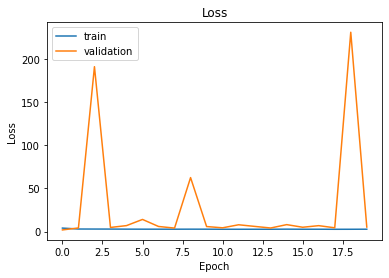

SystemExit: ignored

/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py:3334: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [19]:
def main(_):
    tf.compat.v1.reset_default_graph()
    if not os.path.exists(args.ckpt_dir):
        os.makedirs(args.ckpt_dir)
    if not os.path.exists(args.test_dir):
        os.makedirs(args.test_dir)

    lr = args.lr * np.ones([args.epoch])
    lr[30:] = lr[0] / 10.0
    if args.use_gpu:
        # added to control the gpu memory
        print("GPU\n")
        gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.9)
        with tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options)) as sess:
            model = denoiser(sess)
            if args.phase == 'train':
                denoiser_train(model, lr=lr)
            elif args.phase == 'test':
                denoiser_test(model)
            else:
                print('[!]Unknown phase')
                exit(0)
    else:
        print("CPU\n")
        with tf.compat.v1.Session() as sess:
            model = denoiser(sess)
            if args.phase == 'train':
                denoiser_train(model, lr=lr)
            elif args.phase == 'test':
                denoiser_test(model)
            else:
                print('[!]Unknown phase')
                exit(0)

def test():
 #   gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)
    
    gpu_options = tf.compat.v1.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.9)
    with tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options)) as sess:
      model = denoiser(sess)
      denoiser_test(model)

if __name__ == '__main__':
    tf.compat.v1.app.run()